## Ecuación de Ondas utilizando diferencias finitas y el método de líneas

Autores: Oscar Reula, Joaquín Pelle, Pablo Montes

Utilizaremos el paquete `DifferentialEquations.jl`. 
Este notebook contiene modificaciones de ejemplos de las siguientes dos páginas:

https://tutorials.sciml.ai/html/introduction/03-optimizing_diffeq_code.html

http://juliamatrices.github.io/BandedMatrices.jl/latest/#Creating-banded-matrices-1

## Método de líneas
Resolveremos ecuaciones hiperbólicas utilizando el *método de líneas* y aproximaciones de *diferencias finitas*. Esto significa que si partimos de un sistema escalar de la forma

\begin{equation}
u_t = u_x
\end{equation}

y lo aproximaremos en un comienzo por un operador de diferencias finitas $D_x$ en la dirección espacial, para obtener

\begin{equation}
v_t = D_x\; v.
\end{equation}

Donde $v$ es una versión de $u$ discretizada *solo* en el espacio. Esto es, si tomamos una grilla de $N$ puntos, $v$ será un vector de $N$ elementos que depende contínuamente en el tiempo. 

En este punto, tenemos efectivamente un sistema de ecuaciones ordinarias de dimensión $N$, al cual podemos aproximar utilizando un integrador ODE adecuado. De esta manera terminamos con una discretización en espacio y en tiempo.

## Ecuación de Onda

Resolveremos la ecuación de onda 
\begin{equation}
\phi_{tt} = \phi_{xx}
\end{equation}

Para expresarla en forma estándar definiremos dos nuevas variables, $u := \phi_x$ y $v := \phi_t$. Este sistema entonces se convierte en

$$
\begin{align}
\phi_t & = & v \\
v_t & = & u_x \\
u_t & = & v_x,
\end{align}
$$

donde hemos usado que $u_t := \phi_{xt} = \phi_{tx} := v_x$, y $v_t :=\phi_{tt} = \phi_{xx} = u_x$.  

Dado que la ecuación para $\phi$ puede ser integrada una vez conocidos $(u,v)$, y que $\phi$ no es necesario para resolver el resto del sistema, lo ignoraremos por el momento.

### Diagonalización del sistema

Si definimos las variables $u^{+} = u+v$ y $u^{-} = u-v$ podemos obtener un sistema diagonalizado, 

$$
\begin{align}
u^+_t & = & u^+_x \\
u^-_t & = & -u^-_x,
\end{align}
$$
donde la solución son dos ondas independientes, $u^{+}$ hacia la izquierda y $u^{-}$ hacia la derecha:

$$
\begin{align}
u^{+}(x,t) = u^{+}_0(x+t)\\
u^{-}(x,t) = u^{-}_0(x-t)
\end{align}
$$

Por lo tanto, las soluciones del sistema original serán combinaciones lineales de estas dos soluciones, las cuales dependen del dato inicial.

Por ejemplo, si tomamos como dato inicial $\phi_0(x) = e^{-x^{2}}$ y $\phi_t(x, t=0) = 0$ con condiciones periódicas de contorno en el intervalo $(-4,4)$, la solución exacta será

┌ Info: Saved animation to 
│   fn = /Users/reula/Docencia/PDE/pde/2021/Numericos/Tarea_2/Ejemplo_Onda.gif
└ @ Plots /Users/reula/.julia/packages/Plots/0MO2T/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Docencia/PDE/pde/2021/Numericos/Tarea_2/Ejemplo_Onda.gif")
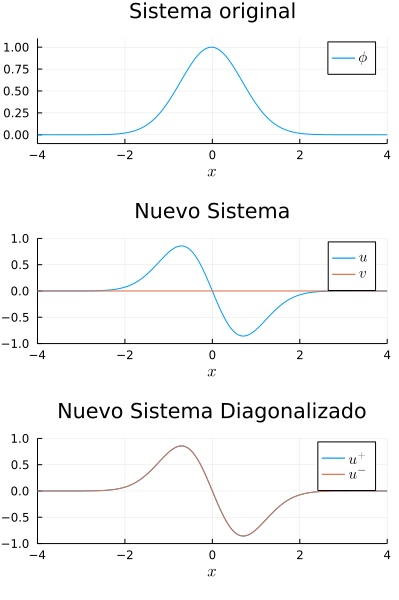

In [1]:
using Plots
N = 201
dx = 8.0/(N-1)
x = range(-4.0, 4.0, length = N) #valores espaciales
tiempos = range(0, 8, length = 200)              #valores temporales

function return_to_interval(xini::Number, xfin::Number, x)
    #Esta función toma un valor x y lo retorna al intervalo [xini, xfin)
    length = xfin - xini
    offset = x - xini
    factor = offset / length
    x = xini + (factor - floor(factor))*length
end

function up_0(x)
    #(u^+)_0
    x = return_to_interval(-4,4,x)
    return -2*x*exp(-(x)^2) 
end
function um_0(x)
    #(u^-)_0
    x = return_to_interval(-4,4,x)
    return -2*x*exp(-(x)^2)
end

anim = @animate for t in tiempos
    up = up_0.(x.+t)
    um = um_0.(x.-t)
    u = 0.5*(up+um)
    v = 0.5*(up-um)
    ϕ = [dx*sum(u[1:i]) for i in 1:N]
    ϕ = ϕ .- minimum(ϕ)
    lfs = 10
    p1 = plot(x, ϕ, label = "\$ \\phi \$", ylim = (-0.1, 1.1), xlim = (-4,4), 
        xlabel = "\$x\$",legendfontsize = lfs)
    title!(p1, "Sistema original")
    p2 = plot(x, u, label = "\$u\$",legendfontsize = lfs)
    plot!(p2, x, v, label = "\$v\$", ylim = (-1,1), xlim = (-4,4),
        xlabel = "\$x\$", legendfontsize = lfs)
    title!(p2, "Nuevo Sistema")
    p3 = plot(x, up, label = "\$u^{+}\$", legendfontsize = lfs)
    plot!(p3, x, um, label = "\$u^{-}\$", ylim = (-1,1), xlim = (-4,4),
        xlabel = "\$x\$", legendfontsize = lfs)
    title!(p3, "Nuevo Sistema Diagonalizado")
    plot(p1, p2, p3, layout = (3,1), size=(400,600))
end
gif(anim, "Ejemplo_Onda.gif", fps = 30)

Estamos usando Julia, por lo que cargaremos algunos paquetes para manejar matrices, resolver ODEs y graficar.

In [3]:
using OrdinaryDiffEq  #Esta es solo una parte del paquete DifferentialEquations
#using DifferentialEquations
using Plots
using LinearAlgebra
import Pkg; Pkg.add("BandedMatrices")
using BandedMatrices
using SparseArrays

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ImageMagick_jll ─ v6.9.12+3
   Installed HDF5_jll ──────── v1.12.2+2
    Updating `~/.julia/environments/v1.7/Project.toml`
  [aae01518] + BandedMatrices v0.16.13
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [0234f1f7] ↑ HDF5_jll v1.12.2+1 ⇒ v1.12.2+2
  [c73af94c] ↑ ImageMagick_jll v6.9.12+2 ⇒ v6.9.12+3
Precompiling project...
  ✓ HDF5_jll
  ✓ ImageMagick_jll
  ✓ gmsh_jll
  ✓ ImageMagick
  ✓ Gmsh
  ✓ GridapGmsh
  ✓ WGLMakie
  7 dependencies successfully precompiled in 88 seconds (455 already precompiled)


Ahora agregamos algunos parámetros para la simulación. Algunos valores son abritrarios, y puede probar jugar con ellos. $N$ es el número de puntos en la discretización espacial. Resolveremos el problema *periódico*, por lo que si la grilla comienza en $1$ y termina en $N$, identificaremos los puntos $(N+1, N+2,...)$ con $(1, 2, ...)$ y los puntos $(0, -1, ...)$ con $(N, N-1, ...)$.

In [9]:
N = 200            # Numeros de puntos en la discretización espacial
L = 1.0            # Intervalo espacial
dx = L/N           # dx
T = 10.            # Tiempo final
dt = 1. *dx        # Tomamos dt ≈ dx/speed_max, para mantener la condición CFL y
                   # Garantizar la estabilidad del algoritmo.

r0=zeros(N,2)      # Discretización de los campos u y v
x = [dx*i for i in 0:N-1];      # Coordenadas x, necesarias para determinar el dato inicial.

Ahora definimos los esquemas de diferencias finitas. Están implementados como matrices que multiplican los vectores de la solución. Las matrices están definidas como dispersas para mayor eficiencia computacional.
En general no es eficiente definir las derivadas numéricas con matrices, pero los casos con los que trabajaremos son bastante sencillos e ilustrativos.

In [4]:
function create_D_2_per(N)
    D_2_per = sparse(Tridiagonal([-0.5 for i in 1:N-1],[0.0 for i in 1:N],[0.5 for i in 1:N-1]))
    D_2_per[1,end] = -0.5
    D_2_per[end,1] = 0.5
    dropzeros!(D_2_per)
    return D_2_per
end


function create_D2_2_per(N)
    D2_2_per = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
    D2_2_per[band(0)] .= -2.0
    D2_2_per[band(1)] .= 1.0
    D2_2_per[band(-1)] .= 1.0
    
    D2_2_per[band(N-1)] .= 1.0
    D2_2_per[band(-N+1)] .= 1.0
    
    D2_2_per = sparse(D2_2_per)
    dropzeros!(D2_2_per)
    return D2_2_per
end

function create_D_4_per(N)
    D_4_per = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
    D_4_per[band(0)] .= 0.0
    D_4_per[band(1)] .= 2.0/3.0
    D_4_per[band(-1)] .= -2.0/3.0
    D_4_per[band(2)] .= -1.0/12.0
    D_4_per[band(-2)] .= 1.0/12.0
    
    D_4_per[band(N-1)] .= -2.0/3.0
    D_4_per[band(N-2)] .= 1.0/12.0
    
    D_4_per[band(-N+1)] .= 2.0/3.0
    D_4_per[band(-N+2)] .= -1.0/12.0
    
    D_4_per = sparse(D_4_per)
    dropzeros!(D_4_per)
    return D_4_per
end

create_D_4_per (generic function with 1 method)

In [5]:
println("Aproximación de segundo orden periódica de la derivada primera:")
println(create_D_2_per(8))
println("Aproximación de cuarto orden periódica de la derivada primera:")
println(round.(create_D_4_per(8), digits = 4))

Aproximación de segundo orden periódica de la derivada primera:

   ⋅    0.5    ⋅     ⋅     ⋅     ⋅     ⋅   -0.5
 -0.5    ⋅    0.5    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -0.5    ⋅    0.5    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -0.5    ⋅    0.5    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -0.5    ⋅    0.5    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.5    ⋅    0.5    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.5    ⋅    0.5
  0.5    ⋅     ⋅     ⋅     ⋅     ⋅   -0.5    ⋅ 
Aproximación de cuarto orden periódica de la derivada primera:

   ⋅       0.6667  -0.0833    ⋅        ⋅        ⋅       0.0833  -0.6667
 -0.6667    ⋅       0.6667  -0.0833    ⋅        ⋅        ⋅       0.0833
  0.0833  -0.6667    ⋅       0.6667  -0.0833    ⋅        ⋅        ⋅ 
   ⋅       0.0833  -0.6667    ⋅       0.6667  -0.0833    ⋅        ⋅ 
   ⋅        ⋅       0.0833  -0.6667    ⋅       0.6667  -0.0833    ⋅ 
   ⋅        ⋅        ⋅       0.0833  -0.6667    ⋅       0.6667  -0.0833
 -0.0833    ⋅        ⋅        ⋅       0.0833  -0.6667    ⋅      

Definimos ahora el lado derecho de las ecuaciones en el método de líneas, es decir, la discretización espacial.

In [7]:
function F!(dr,r,p,t)
    # second order version
    dx, D = p
    h = 1. /dx
    u = @view r[:,1]
    v = @view r[:,2]
    du = @view dr[:,1]
    dv = @view dr[:,2]
    mul!(du, D, v, h, 0)  #du/dt = h*Dv
    mul!(dv, D, u, h, 0)  #dv/dt = h*Du
    #Nota: mul!(C, A, B, α, β) hace la operación α*A*B + β*C y la guarda en C
end

F! (generic function with 1 method)

Ahora damos el dato inicial. En este caso particular, daremos uno en el que $u^{+}$ se anula. Por lo tanto, la única onda que debieramos ver es $u^{-}$ yendo hacia la derecha. Puede jugar y cambiar el dato inicial por otro.

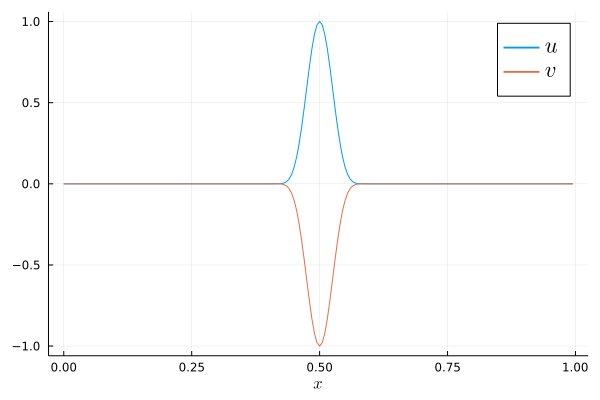

In [10]:
x0 = 0.4; x1 = 0.6
u = @view r0[:,1]
v = @view r0[:,2]

for i in 1:N
    x[i] = dx*(i-1)
    if x[i] > x0 && x[i] < x1
        u[i] = (x[i] - x0)^8 * (x[i] - x1)^8 / (0.5*(x1-x0))^16
        v[i] = -u[i]
    end
end

plot(x, r0, label = ["\$u\$" "\$v\$"], xlabel = "\$x\$", legendfontsize = 15)

Definimos dos porblemas con distinta precisión

In [11]:
D_2_per = create_D_2_per(N)
D_4_per = create_D_4_per(N)

p2 = (dx, D_2_per)
p4 = (dx, D_4_per)
@time prob2 = ODEProblem(F!,r0,(0.0,T),p2);
@time prob4 = ODEProblem(F!,r0,(0.0,T),p4);

  1.817714 seconds (1.44 M allocations: 87.428 MiB, 4.24% gc time, 98.64% compilation time)
  0.000126 seconds (265 allocations: 13.156 KiB)


Ahora resolvemos:

In [12]:
@time sol2 = solve(prob2,RK4(),dt=dt);

  9.779853 seconds (7.49 M allocations: 438.561 MiB, 4.15% gc time, 98.34% compilation time)


In [13]:
@time sol4 = solve(prob4,RK4(),dt=dt);

  0.400432 seconds (11.80 k allocations: 28.362 MiB)


Finalmente, graficamos la solución a distintos tiempos. Notemos que, como la velocidad de propagación es $1$ y el sistema es periódico y de longitud espacial $1$, esperamos que para $t = i*1.0$ recuperemos el dato inicial.

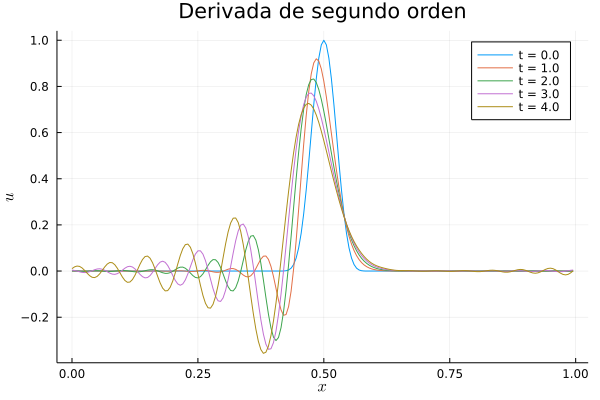

In [11]:
plt = plot()
for i in 0:4
    plot!(plt,x, sol2(T*0.1*i)[:,1], label = "t = $(T*0.1*i)")
end
title!("Derivada de segundo orden")
xlabel!("\$x\$")
ylabel!("\$u\$")
display(plt)

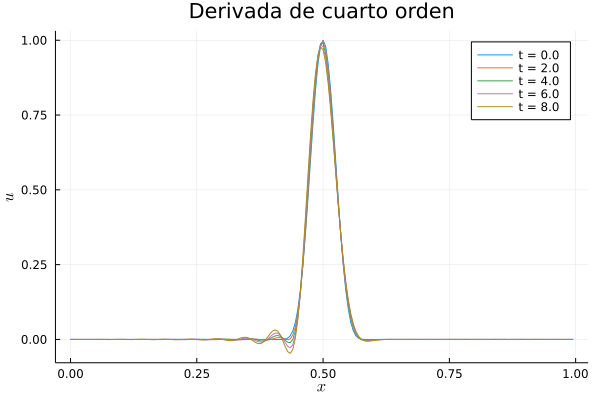

In [12]:
plt = plot()
for i in 0:4
    plot!(plt,x, sol4(T*0.2*i)[:,1], label = "t = $(T*0.2*i)")
end
title!("Derivada de cuarto orden")
xlabel!("\$x\$")
ylabel!("\$u\$")
display(plt)

┌ Info: Saved animation to 
│   fn = /home/pablo/Documentos/FaMAF/Cursos/pde2021/pde/2021/Numericos/Tarea_2/wave_anim_fps10.gif
└ @ Plots /home/pablo/.julia/packages/Plots/CBYO0/src/animation.jl:114


Plots.AnimatedGif("/home/pablo/Documentos/FaMAF/Cursos/pde2021/pde/2021/Numericos/Tarea_2/wave_anim_fps10.gif")
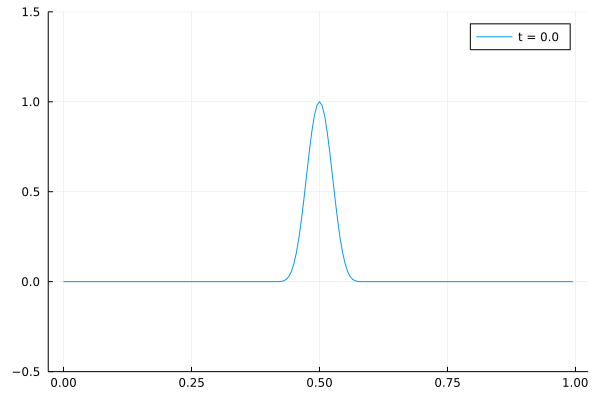

In [13]:
anim = @animate for i in 0:100
    plot(x, sol2(i*T/100)[:,1], ylim = (-0.5, 1.5), label = "t = $(i*T/100)")
end

gif(anim, "wave_anim_fps10.gif", fps = 10)
    